### Preparation

In [ ]:
!pip install Tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 KB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00


## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### File preprocessing

In [ ]:
# # Show where to maually clean file - No need to be ran again!

# import csv

# with open('/content/gdrive/MyDrive/ADM/sentiment140_cleaned.csv', 'rt') as inp:
#     count = 0
#     for row in csv.reader(inp):
#       print(count)
#       count += 1

In [ ]:
import pandas as pd

filepath = '/content/gdrive/MyDrive/ADM/sentiment140_cleaned.csv'
df = pd.read_csv(filepath)

# leave only the important data
df = df.iloc[:, [0, 5]]
df.columns = ['label', 'text_original']

# change the labels to fit into the neural network
# (from (0 = negative, 2 = neutral, 4 = positive) to (0 = negative, 1 = positive - there were no neutrals in the database))
df['label'][df['label'] == 4] = 1 # positive
print([df[df['label'] == 2]]) # check if there are any neutral texts

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)


<ipython-input-4-4ded47509181>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][df['label'] == 4] = 1 # positive
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


[Empty DataFrame
Columns: [label, text_original]
Index: []]


#### Clean the text:

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer


def clean_text(text,stopwords,lemmatize=False):
  text = text.lower()
  text = re.sub(r"<br />", "", text)
  text = re.sub(r"[,;`^\.\"!?:_()%&{}*+\#\$-/\\<>=@|~\]\[]", " ", text)
  words = text.split()
  words = list(filter(lambda w: not w in stopwords, words))

  # normalizes a word with the context of vocabulary and morphological analysis of words in text
  if lemmatize:
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(token) for token in words]
    words = [lemmatizer.lemmatize(token, "v") for token in words]
  return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['text'] = df.text_original.apply(lambda t:clean_text(t,stopwords))

In [ ]:
df.head(10)

,label,text_original,text
0,1,@Shastri_Philip somepeople have to go for work...,shastri philip somepeople go work time
1,0,@MartySchwarz Hey Marty. What gauge strings do...,martyschwarz hey marty gauge strings use bough...
2,0,@fiddlehead ?wrap them in plastic? don't know,fiddlehead wrap plastic know
3,1,@featureBlend My pleasure! Really enjoyed that...,featureblend pleasure really enjoyed link
4,1,Phone with tylerrrrr,phone tylerrrrr
5,0,ah... summer in bethel - hope it doesn't rain...,ah summer bethel hope rain summer
6,1,@sharonhayes..where is the song?,sharonhayes song
7,1,"I'm gonna tidy up my room (at 8am, during summ...",gonna tidy room 8am summer break totally norma...
8,1,@dbgrady lol that was a great movie,dbgrady lol great movie
9,0,@whaleflipflops boo for tix going up that stinks,whaleflipflops boo tix going stinks


#### Split to train and test

In [ ]:
train_ratio = 0.7
max_train = int(train_ratio * len(df))
df_train = df.iloc[:max_train]
df_test = df.iloc[max_train:]

In [ ]:
df_train.head(10)

,label,text_original,text
0,1,@Shastri_Philip somepeople have to go for work...,shastri philip somepeople go work time
1,0,@MartySchwarz Hey Marty. What gauge strings do...,martyschwarz hey marty gauge strings use bough...
2,0,@fiddlehead ?wrap them in plastic? don't know,fiddlehead wrap plastic know
3,1,@featureBlend My pleasure! Really enjoyed that...,featureblend pleasure really enjoyed link
4,1,Phone with tylerrrrr,phone tylerrrrr
5,0,ah... summer in bethel - hope it doesn't rain...,ah summer bethel hope rain summer
6,1,@sharonhayes..where is the song?,sharonhayes song
7,1,"I'm gonna tidy up my room (at 8am, during summ...",gonna tidy room 8am summer break totally norma...
8,1,@dbgrady lol that was a great movie,dbgrady lol great movie
9,0,@whaleflipflops boo for tix going up that stinks,whaleflipflops boo tix going stinks


In [ ]:
df_test.head(10)

,label,text_original,text
1119998,0,@ Home ... really really really bored,home really really really bored
1119999,1,http://twitpic.com/61ff5 - (left side)Look at ...,http twitpic com 61ff5 left side look shoe fri...
1120000,0,is not looking fwd to the next 2 weeks at work...,looking fwd next 2 weeks work cindy work gonna...
1120001,1,@katiecupcake I live in South Central PA. York,katiecupcake live south central pa york
1120002,0,Drumming is too tiring .. I may quit and swit...,drumming tiring may quit switch harp
1120003,0,@erinbatt It's not just you... it does feel em...,erinbatt feel emptier peep
1120004,1,@robwhite Happy Birthday!,robwhite happy birthday
1120005,0,"Guess what, VZ &quot;New Every Two&quot; isn't...",guess vz quot new every two quot contract end ...
1120006,0,It sucks when you like some one but they dont ...,sucks like one dont feel
1120007,0,@TweetRamona haah all my friends say my metabo...,tweetramona haah friends say metabolism change...


# First approach - tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_words = 100_000
vectorizer = TfidfVectorizer(max_features=max_words)
vectorizer.fit(df_train.text)
X_train = vectorizer.transform(df_train.text)
X_test = vectorizer.transform(df_test.text)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1119998, 100000)
(480000, 100000)


              precision    recall  f1-score   support

           0       0.78      0.75      0.77    246414
           1       0.75      0.77      0.76    233586

    accuracy                           0.76    480000
   macro avg       0.76      0.76      0.76    480000
weighted avg       0.76      0.76      0.76    480000



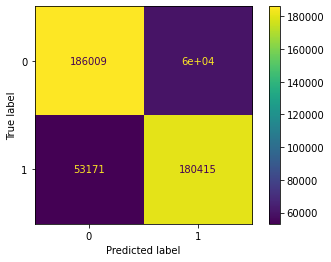

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

model1 = MultinomialNB()

model1.fit(X_train,df_train.label)
y_pred1 = model1.predict(X_test)

print(classification_report(y_pred1,df_test.label))
cm = confusion_matrix(y_pred1,df_test.label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model1.classes_)
disp.plot()

# Second approach - embeddings and fine-tuing of the parameters

### Text preprocessing

Tokenize the words

In [ ]:
import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer

num_words = 10_000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train.text)
seq_train = tokenizer.texts_to_sequences(df_train.text)
seq_test = tokenizer.texts_to_sequences(df_test.text)

# print(seq_train[0])
# print(tokenizer.word_index)

The neural network expects input of equal length. Sequences have to be padded with 0s or shortened to fit the optimized length (long enough to fit most of the texts but not too long if only a few texts are that long).

Text(0.5, 0, 'Number of words')

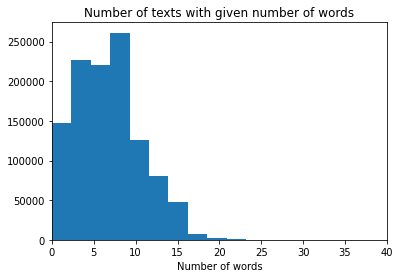

In [ ]:
import matplotlib.pyplot as plt

lens = [len(s) for s in seq_train]
plt.hist(lens, bins=50)
plt.title('Number of texts with given number of words')
plt.xlim([0, 40])
plt.xlabel('Number of texts')
plt.xlabel('Number of words')

In [ ]:
from keras.utils import pad_sequences

maxlen = 15 # based on the histogram
seq_train_padded = pad_sequences(seq_train, maxlen=maxlen)
seq_test_padded = pad_sequences(seq_test, maxlen=maxlen)

Visualization of padding

Example padded sequence:
[ 0  0  0  0  0  0  0  0  0  0  0  0  5 10 14]


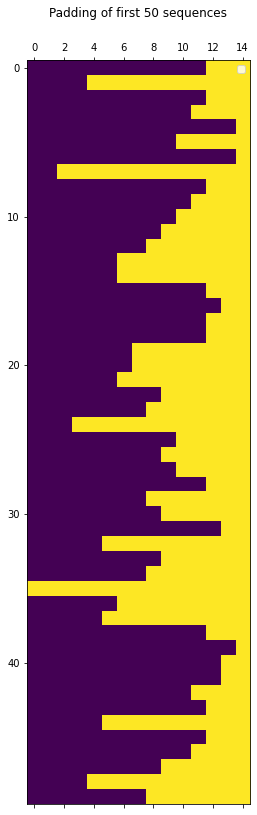

In [ ]:
import numpy as np
print('Example padded sequence:')
print(seq_train_padded[0])

sub_seq = seq_train_padded[0:50,:]
sub_seq = np.where(sub_seq>0, 1, 0)
plt.matshow(sub_seq)
plt.title('Padding of first 50 sequences')
plt.legend(['Padding', 'Words'])

### Model and classification

Model with fine-tuinig

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

def build_model(hp):
  model = Sequential()
  model.add(Embedding(input_dim=10_000,
                      output_dim=hp.Int('output_dim', min_value=8, max_value=64, step=8),
                      input_length=maxlen))
  model.add(Flatten())
  model.add(Dense(2, activation=hp.Choice('activation', ['softmax', 'sigmoid'])))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
import keras_tuner

tuner = keras_tuner.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     overwrite=True)

In [ ]:
seq_train_padded_short = seq_train_padded[:100000]
seq_test_padded_short = seq_test_padded[:30000]
train_labels_short = df_train.label[:100000]
test_labels_short = df_test.label[:30000]

tuner.search(seq_train_padded_short, train_labels_short, epochs=5, validation_data=(seq_test_padded_short, test_labels_short))

best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters()[0]

print(best_hps.get('output_dim'))
print(best_hps.get('activation'))
print(best_hps.get('learning_rate'))

Trial 30 Complete [00h 02m 09s]
val_accuracy: 0.7249333262443542

Best val_accuracy So Far: 0.7633333206176758
Total elapsed time: 00h 29m 46s
56
sigmoid
0.0001


In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 56)            560000    
                                                                 
 flatten (Flatten)           (None, 840)               0         
                                                                 
 dense (Dense)               (None, 2)                 1682      
                                                                 
Total params: 561,682
Trainable params: 561,682
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = best_model.fit(seq_train_padded, df_train.label,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/20
28000/28000 [==============================] - 137s 5ms/step - loss: 0.4751 - accuracy: 0.7755 - val_loss: 0.4761 - val_accuracy: 0.7753
Epoch 2/20
28000/28000 [==============================] - 132s 5ms/step - loss: 0.4618 - accuracy: 0.7844 - val_loss: 0.4764 - val_accuracy: 0.7755
Epoch 3/20
28000/28000 [==============================] - 129s 5ms/step - loss: 0.4538 - accuracy: 0.7896 - val_loss: 0.4793 - val_accuracy: 0.7732
Epoch 4/20
28000/28000 [==============================] - 134s 5ms/step - loss: 0.4466 - accuracy: 0.7941 - val_loss: 0.4838 - val_accuracy: 0.7710
Epoch 5/20
28000/28000 [==============================] - 138s 5ms/step - loss: 0.4401 - accuracy: 0.7981 - val_loss: 0.4887 - val_accuracy: 0.7691
Epoch 6/20
28000/28000 [==============================] - 135s 5ms/step - loss: 0.4344 - accuracy: 0.8017 - val_loss: 0.4941 - val_accuracy: 0.7667
Epoch 7/20
28000/28000 [==============================] - 134s 5ms/step - loss: 0.4296 - accuracy: 0.8042 - val_

Text(0.5, 1.0, 'Training and validation loss')

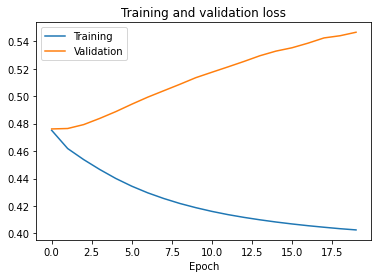

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.title('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

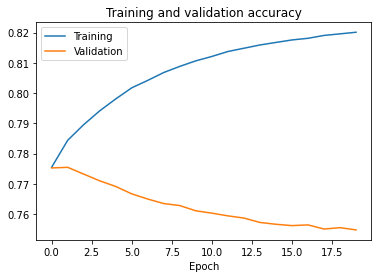

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.title('Training and validation accuracy')

15000/15000 [==============================] - 19s 1ms/step
              precision    recall  f1-score   support

           0       0.75      0.76      0.75    237028
           1       0.76      0.75      0.76    242972

    accuracy                           0.75    480000
   macro avg       0.75      0.75      0.75    480000
weighted avg       0.75      0.75      0.75    480000



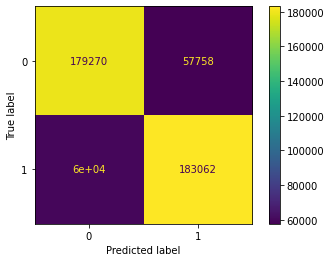

In [ ]:
from sklearn.metrics import classification_report

preds = best_model.predict(seq_test_padded)
y_pred = np.argmax(preds, axis=1)
print(classification_report(y_pred,df_test.label))
cm = confusion_matrix(y_pred,df_test.label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model1.classes_)
disp.plot()